In [1]:
import os
import csv
import sys
import json
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import roc_auc_score

from collections import defaultdict

%matplotlib inline

In [2]:
sys.path.append('../src')
import plot_helpers as ph
pd.set_option('display.precision', 3)

In [3]:
experiment_id = "10C"
experiment = json.load(open('../analysis.json'))["experiments"][experiment_id]

In [7]:
from IPython.display import Markdown as md
md(f"""
## {experiment['name']}

### Description
{experiment['description']}

### Results
- No significant differences between 125 and 60 words. If anything, 60 works slightly better and that is consistent with our other nwords experiments.

""")


## TAC Training/Testing Split - PubMedBERT, prepend refsource, nwords explore

### Description
Use the TAC training and testing splits instead of randomly splitting. Network used here is PubMedBERT which was found to have better performance in head-to-head comparions (See Experiments 0, 0A, 1, and 10A).

### Results
- No significant differences between 125 and 60 words. If anything, 60 works slightly better and that is consistent with our other nwords experiments.



<ipython-input-5-a7d67d3f780f>:60: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 2, 2)
<ipython-input-5-a7d67d3f780f>:60: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 2, 2)


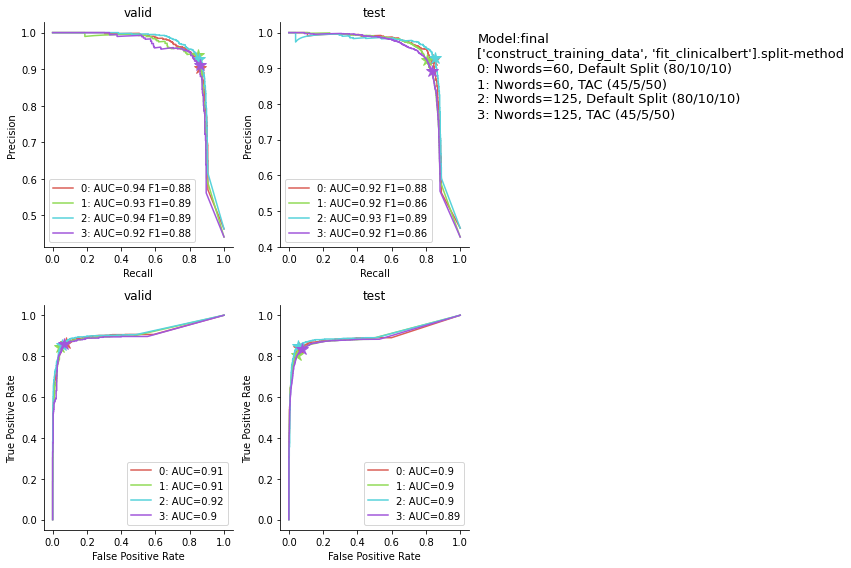

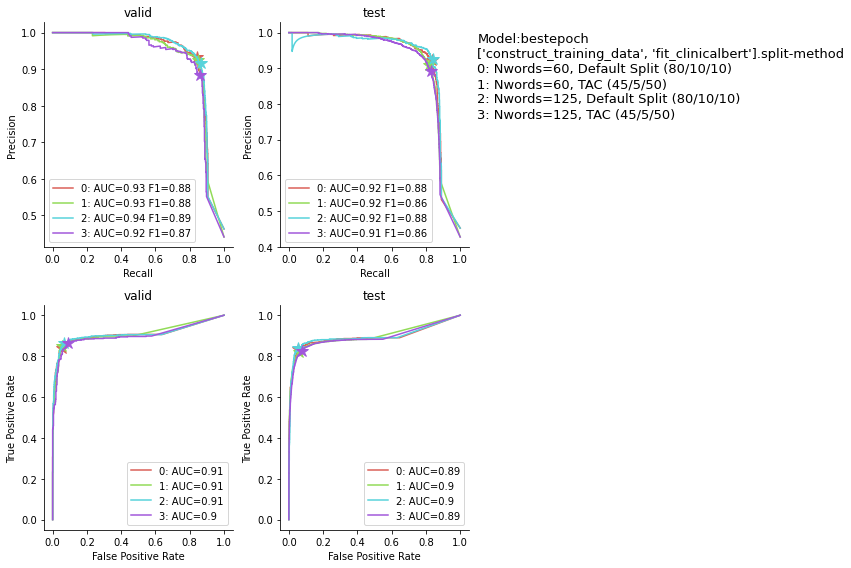

In [5]:
perfdata = defaultdict(lambda: defaultdict(list))

for modeltype in ('final', 'bestepoch'):
    resfiles = experiment[modeltype]
    colors = sns.color_palette("hls", len(resfiles))

    plt.figure(figsize=(12,8))
    plotcounter = 1


    for split in ('valid', 'test'):
        plt.subplot(2, 2, plotcounter)
        plotcounter += 1
        plt.title(split)

        for i, resfile in enumerate(resfiles):

            df = pd.read_csv(os.path.join('..', resfile), index_col=0)
            df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
            split_df = df[df['split']==split]

            prdata = ph.prdata(split_df['label'], split_df['Pred1'])
            perfdata[(modeltype, split)]['prdata'].append(prdata)
            
            plt.plot(prdata['recall'], prdata['precision'], color=colors[i], 
                     label=f'{i}: AUC={prdata["pr_auc"]:.2} F1={prdata["max_f1"]:.2}'
                    )
            plt.plot([prdata['max_f1_recall']], [prdata['max_f1_precision']], '*', color=colors[i], markersize=12)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        sns.despine()

    for split in ('valid', 'test'):
        plt.subplot(2, 2, plotcounter)
        plotcounter += 1
        plt.title(split)

        for i, resfile in enumerate(resfiles):

            df = pd.read_csv(os.path.join('..', resfile), index_col=0)
            df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
            split_df = df[df['split']==split]

            prdata = ph.prdata(split_df['label'], split_df['Pred1'])
            rocdata = ph.rocdata(split_df['label'], split_df['Pred1'], prdata['max_f1_threshold'])
            perfdata[(modeltype, split)]['rocdata'].append(rocdata)
            
            plt.plot(rocdata['fpr'], rocdata['tpr'], color=colors[i], 
                     label=f'{i}: AUC={rocdata["roc_auc"]:.2}'
                    )
            plt.plot([rocdata['max_f1_fpr']], [rocdata['max_f1_tpr']], '*', color=colors[i], markersize=12)

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        sns.despine()

    plt.subplot(2, 2, 2)
    reflegend = f'Model:{modeltype}\n{experiment["factor"]}\n' + '\n'.join([f"{i}: {s}" for i, s in enumerate(experiment['labels'])])
    plt.text(1.1, 1.0, reflegend, fontsize=13, verticalalignment='top')
    #plt.suptitle(modeltype)
    plt.tight_layout()
    
    plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}.pdf')

3.2979042530059814


,Factor,Valid Precision,Valid Recall,Valid F1,Valid AUPR,Valid AUROC,Threshold,Test Precision,Test Recall,Test F1,Test AUPR,Test AUROC
0,"Nwords=60, Default Split (80/10/10)",0.932,0.841,0.884,0.933,0.906,3.210,0.924,0.834,0.877,0.922,0.893
1,"Nwords=60, TAC (45/5/50)",0.924,0.848,0.884,0.929,0.910,3.298,0.909,0.819,0.861,0.919,0.899
2,"Nwords=125, Default Split (80/10/10)",0.918,0.863,0.890,0.935,0.908,3.046,0.926,0.840,0.881,0.921,0.895
3,"Nwords=125, TAC (45/5/50)",0.885,0.862,0.873,0.922,0.900,2.949,0.892,0.827,0.858,0.913,0.892


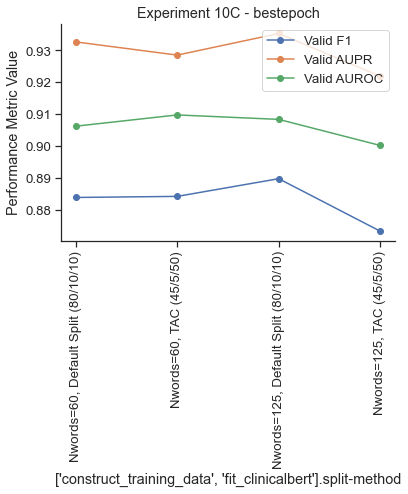

In [6]:
modeltype = 'bestepoch'
key = (modeltype, 'valid')
dfdata = {
    'Factor': experiment['labels'],
    'Valid Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Valid Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Valid F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Valid AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Valid AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
    'Threshold': [d['max_f1_threshold'] for d in perfdata[key]['prdata']]
}

valid = pd.DataFrame(dfdata)

key = (modeltype, 'test')
dfdata = {
#     'Factor': experiment['labels'],
    'Test Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Test Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Test F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Test AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Test AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

test = pd.DataFrame(dfdata)

sns.set(style='ticks', font_scale=1.2)

for col in ('Valid F1', 'Valid AUPR', 'Valid AUROC'):
    plt.plot(valid[col], 'o-', label=col)

plt.xticks(ticks = range(len(valid)), labels = valid['Factor'], rotation=90)
plt.xlabel(experiment['factor'])
plt.ylabel('Performance Metric Value')
plt.title(f"Experiment {experiment_id} - {modeltype}")
plt.legend()
sns.despine()

plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}-summary-stats.pdf')

print(valid['Threshold'][1])
pd.concat([valid, test], axis=1)

In [8]:
md(f"""
## Replication using TAC Official Eval Script

### Steps

1. Confirm gold standard files are generated by running:

```
python3 src/tac_create_gold_xml.py --section AR
```

2. Create the prediction xml files using:

```
python3 src/tac_generate_xml.py --section AR --results {experiment[modeltype][1]} --threshold {valid['Threshold'][1]}
```
```
python3 src/tac_generate_xml.py --section AR --results {experiment[modeltype][3]} --threshold {valid['Threshold'][3]}

```

3. Run official eval script:

```
python3 src/tac_official_eval_script.py -3 ./data/200_xml/AR ./data/xml_output/AR/{os.path.split(experiment[modeltype][1])[-1].split('.')[0]}
```
```
python3 src/tac_official_eval_script.py -3 ./data/200_xml/AR ./data/xml_output/AR/{os.path.split(experiment[modeltype][3])[-1].split('.')[0]}
```

### Results

| Model        | Macro-F1    |
| -----------  | ----------- |
| Nwords=60    | 83.25       |
| Nwords=125   | 82.92       |

""")


## Replication using TAC Official Eval Script

### Steps

1. Confirm gold standard files are generated by running:

```
python3 src/tac_create_gold_xml.py --section AR
```

2. Create the prediction xml files using:

```
python3 src/tac_generate_xml.py --section AR --results ./results/grouped-mean-bestepoch-bydrug-PMB_14-AR-60-all_222_TAC_25_1e-06_128_128.csv --threshold 3.2979042530059814
```
```
python3 src/tac_generate_xml.py --section AR --results ./results/grouped-mean-bestepoch-bydrug-PMB_14-AR-125-all_222_TAC_25_1e-06_256_32.csv --threshold 2.9487695693969727

```

3. Run official eval script:

```
python3 src/tac_official_eval_script.py -3 ./data/200_xml/AR ./data/xml_output/AR/grouped-mean-bestepoch-bydrug-PMB_14-AR-60-all_222_TAC_25_1e-06_128_128
```
```
python3 src/tac_official_eval_script.py -3 ./data/200_xml/AR ./data/xml_output/AR/grouped-mean-bestepoch-bydrug-PMB_14-AR-125-all_222_TAC_25_1e-06_256_32
```

### Results

| Model        | Macro-F1    |
| -----------  | ----------- |
| Nwords=60    | 81.61       |
| Nwords=125   | 78.92       |



,Factor,Valid Precision,Valid Recall,Valid F1,Valid AUPR,Valid AUROC,Threshold,Test Precision,Test Recall,Test F1,Test AUPR,Test AUROC
0,"Nwords=60, Default Split (80/10/10)",0.887,0.870,0.879,0.938,0.917,1.666,0.924,0.829,0.874,0.921,0.902
1,"Nwords=60, TAC (45/5/50)",0.878,0.820,0.848,0.909,0.893,1.719,0.881,0.823,0.851,0.906,0.890
2,"Nwords=125, Default Split (80/10/10)",0.924,0.848,0.884,0.944,0.925,1.776,0.910,0.834,0.871,0.926,0.909
3,"Nwords=125, TAC (45/5/50)",0.851,0.834,0.842,0.905,0.886,2.570,0.856,0.821,0.838,0.895,0.878


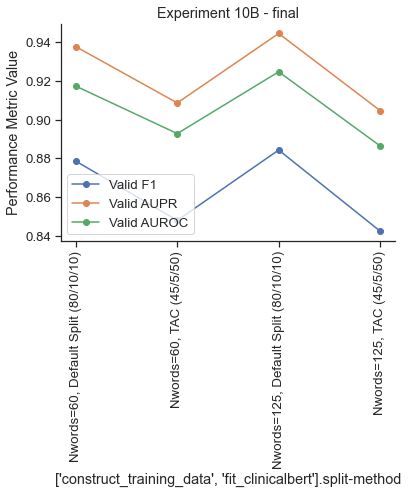

In [20]:
modeltype = 'final'
key = (modeltype, 'valid')
dfdata = {
    'Factor': experiment['labels'],
    'Valid Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Valid Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Valid F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Valid AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Valid AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
    'Threshold': [d['max_f1_threshold'] for d in perfdata[key]['prdata']]
}

valid = pd.DataFrame(dfdata)

key = (modeltype, 'test')
dfdata = {
#     'Factor': experiment['labels'],
    'Test Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Test Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Test F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Test AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Test AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

test = pd.DataFrame(dfdata)

sns.set(style='ticks', font_scale=1.2)

for col in ('Valid F1', 'Valid AUPR', 'Valid AUROC'):
    plt.plot(valid[col], 'o-', label=col)

plt.xticks(ticks = range(len(valid)), labels = valid['Factor'], rotation=90)
plt.xlabel(experiment['factor'])
plt.ylabel('Performance Metric Value')
plt.title(f"Experiment {experiment_id} - {modeltype}")
plt.legend()
sns.despine()

plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}-summary-stats.pdf')

pd.concat([valid, test], axis=1)

In [13]:
for fn in experiment['epochperf']:
    df = pd.read_csv(os.path.join('..', fn))
    print(fn, np.argmin(df['valid_loss']))

./results/epoch-results-CB_14-AR-60-all_222_24_25_1e-06_128_128.csv 9
./results/epoch-results-CB_14-AR-60-all_222_TAC_25_1e-06_128_128.csv 11
./results/epoch-results-CB_14-AR-125-all_222_24_25_1e-06_256_32.csv 9
./results/epoch-results-CB_14-AR-125-all_222_TAC_25_1e-06_256_32.csv 5
